# **Capstone Project**

Introduction to Data Science (DS-GA1001)

Code by: Jiashu Liu, Jiayu Gu, and Tianyi Li

Date: 12-19-23

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from sklearn import datasets
from sklearn.decomposition import PCA as sk_PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, learning_curve, cross_validate
from sklearn.metrics import r2_score, make_scorer
from sklearn.cluster import KMeans as sk_KMeans, DBSCAN as sk_DBSCAN
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
import math
import pandas as pd
#!pip install scikit-surprise
import surprise
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split as sp_train_test_split
from surprise.accuracy import rmse
from collections import defaultdict
np.random.seed(18630908)
random.seed(18630908)

In [21]:
# Load in two datasets
spotify_data = pd.read_csv('spotify52kData.csv')
#ratings_data = pd.read_csv('/spotify52kData.csv', header = None)
print('Preview of Spotify data: ')
print(spotify_data.head())
print('\n')

# print('Preview of starRatings data: ')
# print(ratings_data.head())

Preview of Spotify data: 
   songNumber                 artists  \
0           0             Gen Hoshino   
1           1            Ben Woodward   
2           2  Ingrid Michaelson;ZAYN   
3           3            Kina Grannis   
4           4        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration  explicit  danceability  \
0                      Comedy          73    230666     False         0.676   
1            Ghost - Acoustic          55    149610     False         0.420   
2              To Begin Again          57    210826     False         0.438   
3  Can't Help Falling In Love          71    201933     False         0.26

# # New Section

In [22]:
# Check for missing values in Spotify data
missing_spotify_col = spotify_data.isna().sum() # column-wise
missing_spotify_row = spotify_data.isna().sum(axis = 1) # row-wise
#print("Missing values in Spotify data columns:\n", missing_spotify_col)
#print("Missing values in Spotify data rows:\n", missing_spotify_row)
total_missing = spotify_data.isna().sum().sum()
print(f"Total number of NAs in the Spotify dataset: {total_missing}")

Total number of NAs in the Spotify dataset: 0


6374


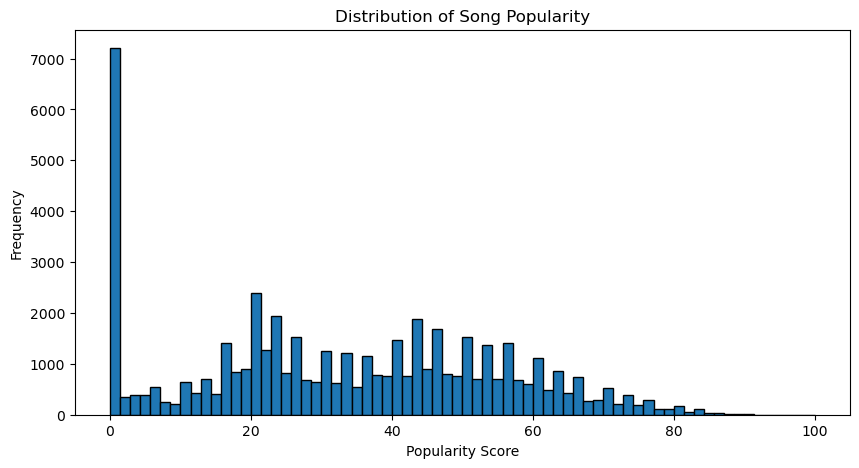

In [23]:
# Check zero popularity
num_zero_popularity = (spotify_data['popularity'] == 0).sum()
print(num_zero_popularity)
# Plot popularity distribution
plt.figure(figsize=(10, 5))
spotify_data['popularity'].hist(bins=70, edgecolor='black')
plt.title('Distribution of Song Popularity')
plt.xlabel('Popularity Score')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

In [24]:
# Remove rows with popularity equal 0
spotify_data = spotify_data[spotify_data['popularity'] != 0]


1) Is there a relationship between song length and popularity of a song? If so, is it positive or negative?


<function matplotlib.pyplot.show(close=None, block=None)>

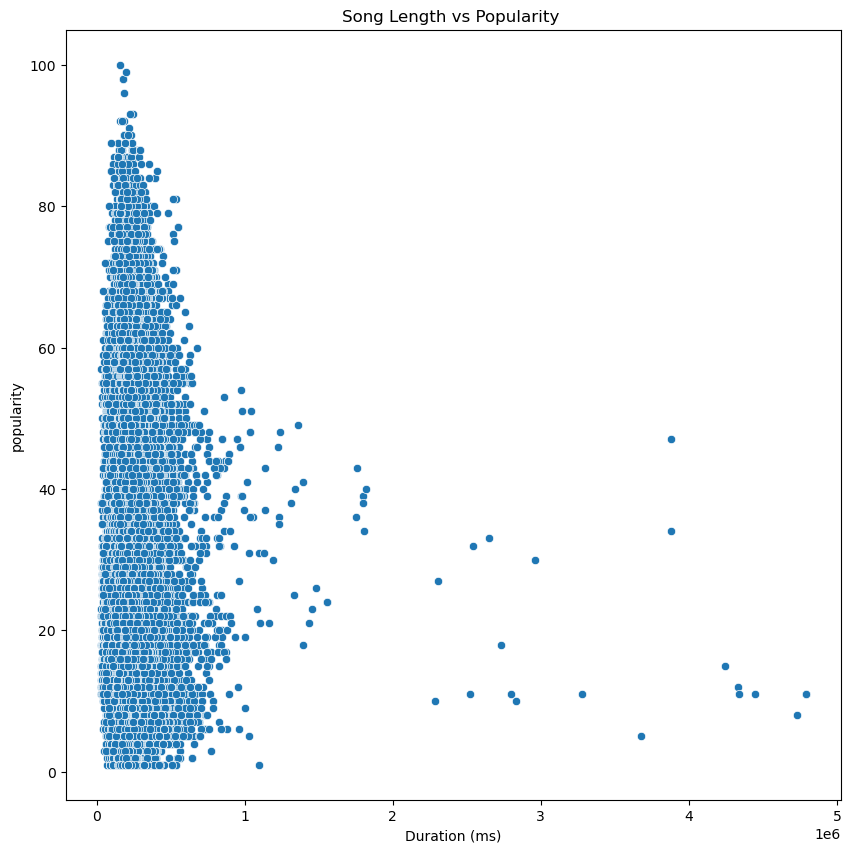

In [25]:
# Visualize the relationship with a scatterplot
plt.figure(figsize = (10, 10))
sns.scatterplot(data = spotify_data, x = 'duration', y = 'popularity')
plt.title('Song Length vs Popularity ')
plt.xlabel('Duration (ms)')
plt.ylabel('popularity')
plt.show


In [26]:
# Calculate the correlation bewteen song length and popularity
correlation = spotify_data[['duration', 'popularity']].corr()
print("Correlation coef:\n", correlation)


Correlation coef:
             duration  popularity
duration    1.000000   -0.100043
popularity -0.100043    1.000000


2) Are explicitly rated songs more popular than songs that are not explicit? 

H0: There is no difference in popularity between explicit and non-explicit songs.

Ha: Explicit songs are more popular than non-explicit songs.

In [27]:
# Perform Mann-Whitney U test
explicit_songs = spotify_data[spotify_data['explicit'] == True]['popularity']
non_explicit_songs = spotify_data[spotify_data['explicit'] == False]['popularity']
u_stats, p_val = mannwhitneyu(explicit_songs, non_explicit_songs, alternative='greater')
print("U-statistic:", u_stats)
print("P-value:", p_val)

if p_val < 0.05:
    print("We will reject the null.")
else:
    print("We fail to reject the null")

U-statistic: 108874531.5
P-value: 2.9626001463178775e-18
We will reject the null.


In [28]:
avg_popularity_explicity = spotify_data.groupby('explicit')['popularity'].mean()
print(avg_popularity_explicity)


explicit
False    37.439581
True     40.209829
Name: popularity, dtype: float64


<function matplotlib.pyplot.show(close=None, block=None)>

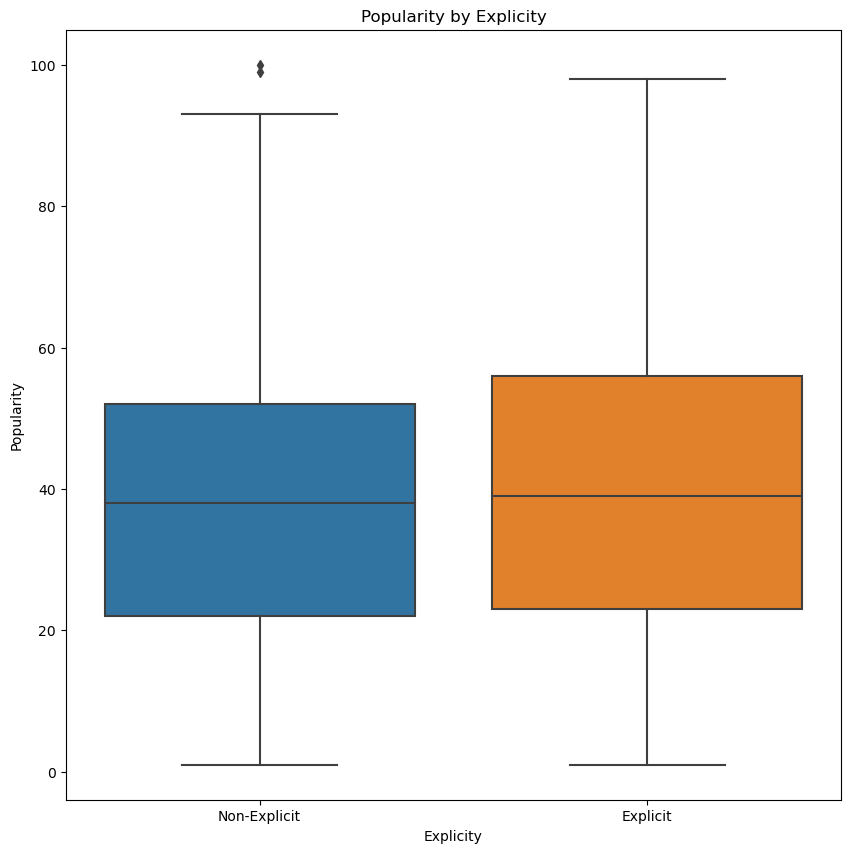

In [29]:
# Box plot for popularity by explicity
plt.figure(figsize = (10, 10))
sns.boxplot(data = spotify_data, x = 'explicit', y = 'popularity')
plt.title('Popularity by Explicity')
plt.xlabel('Explicity')
plt.ylabel('Popularity')
plt.xticks(ticks=[0, 1], labels=['Non-Explicit', 'Explicit'])
plt.show

3) Are songs in major key more popular than songs in minor key?

H0: There's no difference in popularity between songs in major key and songs in minor key.

Ha: Songs in major key is more popular than songs in minor key.

In [30]:
# Perform Mann-Whitney U test
major_key = spotify_data[spotify_data['mode'] == 1]['popularity']
minor_key = spotify_data[spotify_data['mode'] == 0]['popularity']
u_stats, p_val = mannwhitneyu(major_key, minor_key, alternative='greater')
print("U-statistic:", u_stats)
print("P-value:", p_val)

if p_val < 0.05:
    print("We will reject the null.")
else:
    print("We fail to reject the null")


U-statistic: 243630068.5
P-value: 0.936642073259969
We fail to reject the null


In [31]:
avg_popularity_mode = spotify_data.groupby('mode')['popularity'].mean()
print(avg_popularity_mode)

mode
0    37.924661
1    37.629513
Name: popularity, dtype: float64


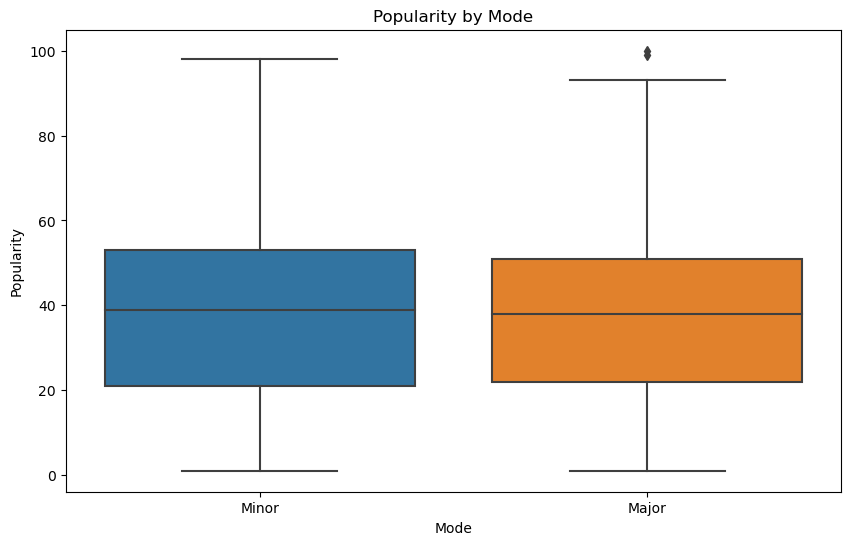

In [32]:
# Box plot for popularity group by mode
plt.figure(figsize=(10, 6))
sns.boxplot(x='mode', y='popularity', data=spotify_data)
plt.title('Popularity by Mode')
plt.xlabel('Mode')
plt.ylabel('Popularity')
plt.xticks(ticks=[0, 1], labels=['Minor', 'Major'])  # Make sure labels match your data encoding
plt.show()

4) Which of the following 10 song features: duration, danceability, energy, loudness, speechiness,
acousticness, instrumentalness, liveness, valence and tempo predicts popularity best?
How good is this model?

In [33]:
def rms_error(y_true, y_pred):
    """
    Computes root mean squared error.
    """
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [34]:
features = ['duration', 'danceability', 'energy', 'loudness', 
            'speechiness', 'acousticness', 'instrumentalness', 
            'liveness', 'valence', 'tempo']

# Aviod overfitting with cross-validation
kfold=KFold(n_splits=10, shuffle = True, random_state=18630908)
model_performance = {}
for feature in features:
    X = spotify_data[[feature]]
    Y = spotify_data['popularity']
    # Split train and test data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=18630908)
    model = LinearRegression()
    # Make predictions and evaluate model performance on test data
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    rmse = rms_error(Y_test, y_pred)
    r2 = r2_score(Y_test, y_pred)
    print(f"Feature: {feature} - RMSE: {rmse}, R2: {r2}")

Feature: duration - RMSE: 18.913638377045874, R2: 0.010654777256784431
Feature: danceability - RMSE: 18.953732262619862, R2: 0.006455824428880597
Feature: energy - RMSE: 18.889032991424088, R2: 0.013227247532268227
Feature: loudness - RMSE: 18.9576670427813, R2: 0.006043263604522453
Feature: speechiness - RMSE: 18.895781205558993, R2: 0.012522061267447593
Feature: acousticness - RMSE: 18.99494400466743, R2: 0.0021305337151755754
Feature: instrumentalness - RMSE: 18.45108653186636, R2: 0.058453897742120065
Feature: liveness - RMSE: 18.921877044553227, R2: 0.009792683838663607
Feature: valence - RMSE: 19.017089303308566, R2: -0.00019755937111876065
Feature: tempo - RMSE: 18.99936534925462, R2: 0.0016659429028358375


5) Building a model that uses *all* of the song features mentioned in question 1, how well can you
predict popularity? How much (if at all) is this model improved compared to the model in question
4). How do you account for this? What happens if you regularize your model?

In [35]:
def rms_error(y_true, y_pred):
    """
    Computes root mean squared error.
    """
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def plot_with_err(x, data, **kwargs):
    """
    Plots the scoring metric w.r.t. to varying hyperparameter. Highlights the area with 1 standard deviation.
    """
    mu, std = data.mean(1), data.std(1) # Mean and std taken across columns.
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2) # Function for plotting between two horizontal lines y1=mu-std and y2=mu+std

In [36]:
# Re-build model with all the 10 features selected in the previous question
X = spotify_data[features]
Y = spotify_data['popularity']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=18630908)
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
model = LinearRegression()

# Make predictions and evaluate model performance on test data
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
rmse = rms_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)
print(f"RMSE on Test Set: {rmse}")
print(f"R2 Score on Test Set: {r2}")

RMSE on Test Set: 17.72257640531767
R2 Score on Test Set: 0.13133682028885663


In [37]:
# Ridge regularization
X = spotify_data[features]
Y = spotify_data['popularity']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=18630908)
param_grid = {'alpha': [2.0**c for c in np.arange(-5, 10)]}
rms_scorer = make_scorer(rms_error, greater_is_better=False)
grid = GridSearchCV(estimator=Ridge(), param_grid=param_grid, cv=kfold, scoring=rms_scorer)
grid.fit(X_train, Y_train)

# Make predictions and evaluate model performance on test data
best_alpha = grid.best_estimator_.alpha
y_pred = grid.best_estimator_.predict(X_test)
rmse_ridge = rms_error(Y_test, y_pred)
r2_ridge = r2_score(Y_test, y_pred)
print("RMSE (Ridge):", rmse_ridge)
print("R2 Score (Ridge):", r2_ridge)


RMSE (Ridge): 17.72277322846004
R2 Score (Ridge): 0.131317525806816


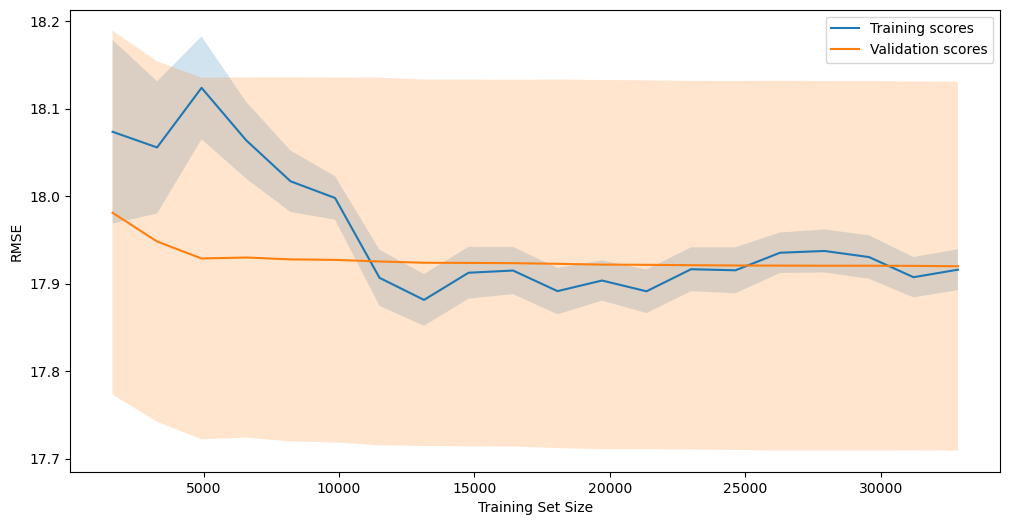

In [38]:
# Plot the learning curve for Ridge Regression
def plot_learning_curve(estimator, X, Y, cv, scoring):
    plt.figure(figsize=(12, 6))
    train_sizes = np.linspace(0.05, 1, 20)
    N_train, train_scores, test_scores = learning_curve(estimator, X, Y, train_sizes=train_sizes, cv=cv, scoring=scoring)
    train_scores = -train_scores
    test_scores = -test_scores

    plot_with_err(N_train, train_scores, label='Training scores')
    plot_with_err(N_train, test_scores, label='Validation scores')
    plt.xlabel('Training Set Size')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()

plot_learning_curve(Ridge(alpha=best_alpha), X_train, Y_train, kfold, rms_scorer)


In [39]:
# LASSO Regularization
X = spotify_data[features]
Y = spotify_data['popularity']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=18630908)
param_grid = {'alpha': [2.0**c for c in np.arange(-12, -1)]}
rms_scorer = make_scorer(rms_error, greater_is_better=False)
grid = GridSearchCV(estimator=Lasso(), param_grid=param_grid, cv=kfold, scoring=rms_scorer)
grid.fit(X_train, Y_train)

# Make predictions and evaluate model performance on test data
best_alpha_lasso = grid.best_estimator_.alpha
y_pred = grid.best_estimator_.predict(X_test)
rmse_lasso = rms_error(Y_test, y_pred)
r2_lasso = r2_score(Y_test, y_pred)
print("RMSE (Lasso):", rmse_lasso)
print("R2 Score (Lasso):", r2_lasso)

RMSE (Lasso): 17.722588770324087
R2 Score (Lasso): 0.1313356081592778


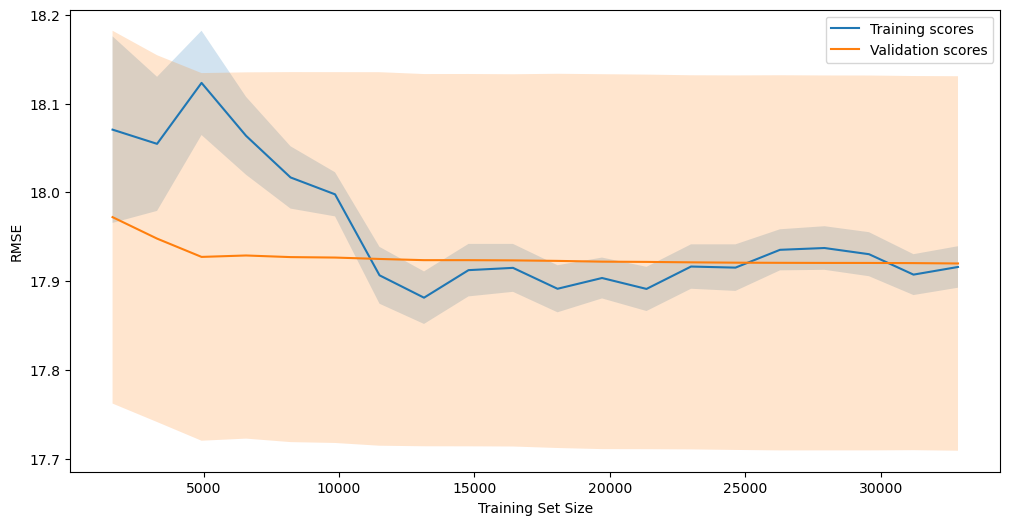

In [40]:
plot_learning_curve(Lasso(alpha=best_alpha_lasso), X_train, Y_train, kfold, rms_scorer)

6) When considering the 10 song features in the previous question, how many meaningful principal components can you extract? What proportion of the variance do these principal components account for? Using these principal components, how many clusters can you identify? Do these clusters reasonably correspond to the genre labels in column 20 of the data?

In [48]:
# (Principal components) Hint: The transformed data, rotated into the new coordinate system by the PCA.
# 10 song features
# features = ['duration', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
predictors = spotify_data[features]
# Z-score
zscored_data = stats.zscore(predictors)
# Fit pca to the data
pca = sk_PCA().fit(zscored_data)
# Eigenvalues
eig_vals = pca.explained_variance_
# Eigenvectors / Loadings
loadings = pca.components_ * -1
# The transformed data
transformed_data = pca.fit_transform(zscored_data) * -1

In [49]:
transformed_data

# Then, we will use Kaiser Criterion to determine meaningful principal components. 

array([[ 0.26633028,  1.45829911, -0.39456158, ...,  0.08475139,
        -0.72821001, -1.0200651 ],
       [-3.67794003,  0.64611695, -0.40421645, ..., -0.34260474,
        -0.21295108,  0.25573409],
       [-1.38760474, -0.40964886, -0.04957216, ...,  0.23580354,
        -0.61024373, -0.52782422],
       ...,
       [ 1.05106331,  1.4625597 , -0.58947997, ...,  0.38494322,
         0.63833296,  0.44036505],
       [ 0.96650007,  1.88857204,  1.0141845 , ..., -0.21360744,
        -0.57085649,  0.35849852],
       [ 0.96650007,  1.88857204,  1.0141845 , ..., -0.21360744,
        -0.57085649,  0.35849852]])

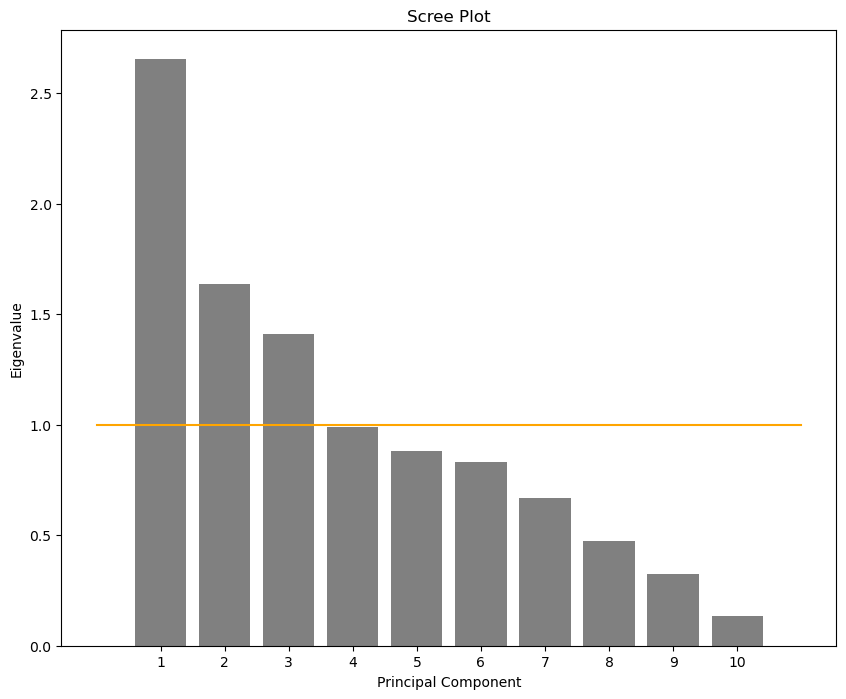

In [50]:
## Kaiser Criterion: Consider all principal components with eigen values greater than 1.0
nComponents = len(eig_vals)
x = np.arange(1, nComponents + 1)

# Plotting
plt.figure(figsize = (10, 8))
plt.bar(x, eig_vals, color = 'gray')
plt.plot([0, nComponents + 1], [1, 1], color = 'orange') # Kaiser criterion line
plt.xticks(x)
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.show()

According to Kaiser Criterion we should consider 3 principal components, so the data after dimensionality reduction 
should be (45626, 3)

In [51]:
# Determine the number of meaningful prinicipal components
kaiser_criterion = eig_vals > 1
selected_predictors = np.sum(kaiser_criterion)
print(selected_predictors)


3


In [52]:
print('Proportion variance explained by the first 3 PCs:',np.sum(eig_vals[:3] / np.sum(eig_vals)).round(3))

Proportion variance explained by the first 3 PCs: 0.57


Therefore, we conclude that we can extract 3 meaningful principal components. These principal components account for 57.0% of the variance.

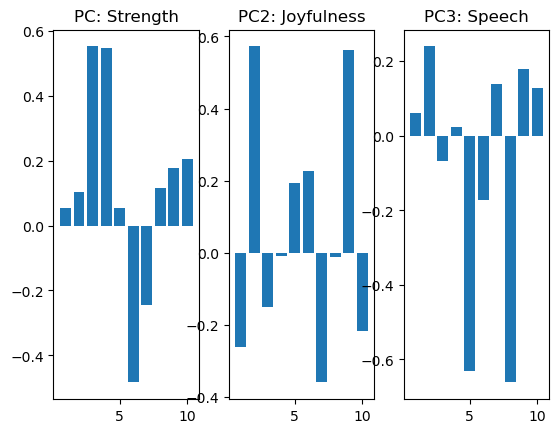

In [54]:
# Plot the loadings
# features = ['duration', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
num_predictors = np.size(predictors,axis=1)
plt.subplot(1, 3, 1) 
plt.bar(np.linspace(1,num_predictors,num_predictors),loadings[0,:]) 
plt.title('PC: Strength')
plt.subplot(1, 3, 2) 
plt.bar(np.linspace(1,num_predictors,num_predictors),loadings[1,:]) 
plt.title('PC2: Joyfulness')
plt.subplot(1, 3, 3) 
plt.bar(np.linspace(1,num_predictors,num_predictors),loadings[2,:]) 
plt.title('PC3: Speech')
plt.show()

Next, we will use K-Means Clustering to find clusters in data.

In [55]:
# proceed data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = sk_PCA(n_components = 3)
selected_data = pca.fit_transform(X_scaled)


In [56]:
# shape should be (45626, 3)
selected_data.shape


(45626, 3)

/Users/jiashuliu/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jiashuliu/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jiashuliu/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jiashuliu/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` wi

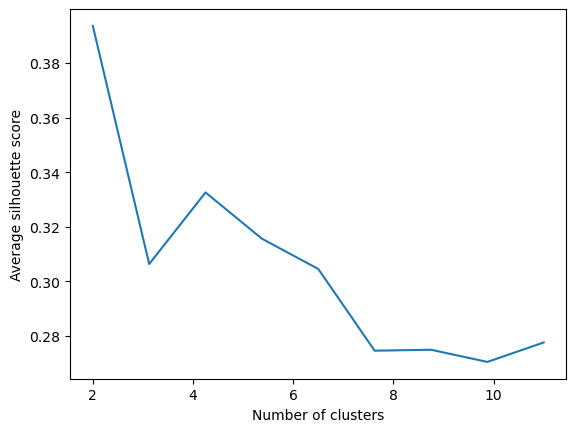

In [59]:
# Since we do not have an idea about class distribution, we will use Silhouette Score choose n_clusters in KMeans.
numClusters = 9 # how many clusters are we looping over? (from 2 to 10)
Q = np.empty([numClusters,1])*np.NaN # init container to store sums

# Compute kmeans:
for ii in range(2, 11):
    kMeans = sk_KMeans(n_clusters = int(ii), random_state = 18630908).fit(selected_data)
    cId = kMeans.labels_
    s = silhouette_score(selected_data, cId)
    Q[ii - 2] = s

plt.plot(np.linspace(2, 11, numClusters), Q)
plt.xlabel('Number of clusters')
plt.ylabel('Average silhouette score')
plt.show()

In [60]:
# Using Elbow method
# And we assume the real optimal number of clusters is found to be 'optimal_n_clusters'
optimal_n_clusters = 2

In [61]:
# Thus, we can identify 2 clusters. Then, we want to check if these clusters reasonably correspond to the genre labels in column 20 of the data.
kmeans = sk_KMeans(n_clusters = optimal_n_clusters, random_state = 18630908)
kmeans.fit(selected_data)
# Add cluster 
spotify_data['cluster'] = kmeans.labels_
# crosstab
correspondence = pd.crosstab(spotify_data['cluster'], spotify_data[spotify_data.columns[19]])
print(correspondence)

track_genre  acoustic  afrobeat  alt-rock  alternative  ambient  anime  \
cluster                                                                  
0                 553       139        44           48      830    256   
1                 391       846       607          467      102    736   

track_genre  black-metal  bluegrass  blues  brazil  ...  grindcore  groove  \
cluster                                             ...                      
0                     47        436    157     181  ...         18      77   
1                    950        554    497     785  ...        979     831   

track_genre  grunge  guitar  happy  hard-rock  hardcore  hardstyle  \
cluster                                                              
0                36     796      7         41        11          0   
1               926     183    950        819       889        928   

track_genre  heavy-metal  hip-hop  
cluster                            
0                     17       39  
1

/Users/jiashuliu/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


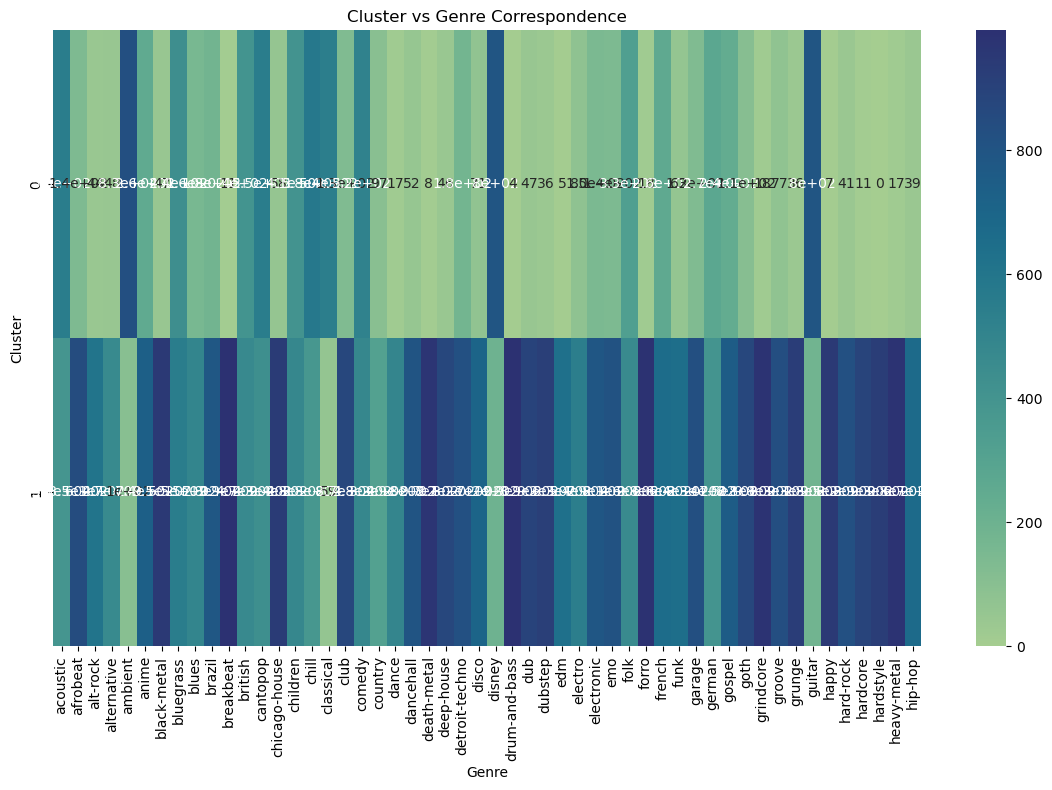

In [62]:
plt.figure(figsize = (14, 8))
sns.heatmap(correspondence, annot = True, cmap = "crest")
plt.title('Cluster vs Genre Correspondence')
plt.xlabel('Genre')
plt.ylabel('Cluster')
plt.show()

7) Can you predict whether a song is in major or minor key from valence using logistic regression or a support vector machine? If so, how good is this prediction? If not, is there a better one?

In [63]:
X = spotify_data[['valence']]
y = spotify_data['mode']
X.shape, y.shape

((45626, 1), (45626,))

In [64]:
# Since it is a large dataset, we will do a tree-based model with cross validation using 80-20 train-test split
# Train & Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 18630908)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((36500, 1), (9126, 1), (36500,), (9126,))

In [65]:
# Logistic Regression
logistic_model = LogisticRegression()
cv_auc_scores = cross_val_score(logistic_model, X, y, cv=5, scoring='roc_auc')
print(f"AUC-ROC score for each fold: {cv_auc_scores}")
print(f"Average AUC-ROC score from 5-fold cross-validation: {np.mean(cv_auc_scores)}")

AUC-ROC score for each fold: [0.49953685 0.4814114  0.5076889  0.50571034 0.47702942]
Average AUC-ROC score from 5-fold cross-validation: 0.49427538071088006


In [66]:
# Use Random Forests to prevent overfitting
forest_model = RandomForestClassifier(random_state = 18630908)
forest_model.fit(X_train, y_train)
forest_predictions = forest_model.predict(X_test)
forest_probabilities = forest_model.predict_proba(X_test)[:, 1]
# Output some metrics
forest_auc_roc = roc_auc_score(y_test, forest_probabilities)
print(f"AUC-ROC score: {forest_auc_roc}")

AUC-ROC score: 0.5274463935931664


In [67]:
# Perform 5-fold cross-validation
cv_auc_scores = cross_val_score(forest_model, X, y, cv=5, scoring='roc_auc')
print(f"AUC-ROC score for each fold: {cv_auc_scores}")
print(f"Average AUC-ROC score from 5-fold cross-validation: {np.mean(cv_auc_scores)}")


AUC-ROC score for each fold: [0.5050274  0.52144305 0.50969955 0.5151449  0.50919737]
Average AUC-ROC score from 5-fold cross-validation: 0.5121024559587808


In [68]:
forest_classification_report = classification_report(y_test, forest_predictions)
print(forest_classification_report)

              precision    recall  f1-score   support

           0       0.41      0.13      0.19      3461
           1       0.62      0.89      0.73      5665

    accuracy                           0.60      9126
   macro avg       0.52      0.51      0.46      9126
weighted avg       0.54      0.60      0.53      9126



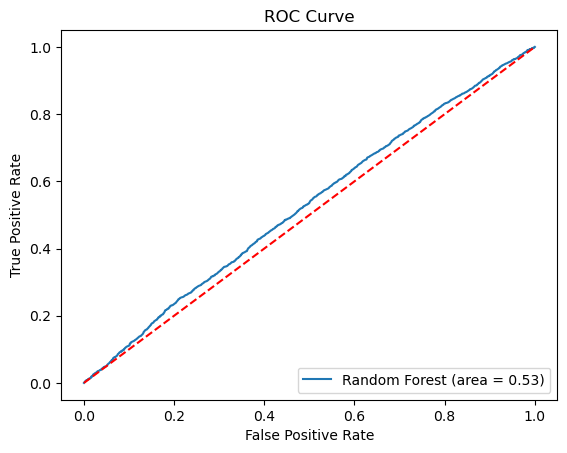

In [69]:
# Plot ROC curve
forest_fpr, forest_tpr, _ = roc_curve(y_test, forest_probabilities)

plt.figure()
plt.plot(forest_fpr, forest_tpr, label = 'Random Forest (area = %0.2f)' % forest_auc_roc)
plt.plot([0, 1], [0, 1], color = 'red', linestyle = 'dashed')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

8) Can you predict genre by using the 10 song features from question 4 directly or the principal components you extracted in question 6 with a neural network? How well does this work?


In [70]:
# 10 song features
X = spotify_data[features]
y = spotify_data['track_genre']

# Standardize & encode
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

In [71]:
# Learn from lab13_deep_learning and make adjustments correspondingly
class Module(object):
    
    def __init__(self):
        self.gradInput = None # stores gradient
        self.output = None # stores loss
        
    def forward(self, *input):
        raise NotImplementedError
        
    def backward(self, *input):
        raise NotImplementedError


class LeastSquareCriterion(Module):
    
    def __init__(self, num_classes=10):
        super(LeastSquareCriterion, self).__init__()
        self.num_classes=num_classes
    
    def forward(self, x, labels):
        target=np.zeros([x.shape[0],self.num_classes])
        for i in range(x.shape[0]):
            target[i,labels[i]]=1
        self.output = np.sum((target-x)**2,axis=0)
        return np.sum(self.output)
    
    def backward(self, x, labels):
        self.gradInput=x
        for i in range(x.shape[0]):
            self.gradInput[i,labels[i]]=x[i,labels[i]]-1 # gradient of loss
        return self.gradInput
    

class Linear(Module):
    
    def __init__(self, in_features, out_features, bias=True):
        super(Linear, self).__init__()
        self.in_features = in_features # dimensions
        self.out_features = out_features # dimensions
        self.weight = math.sqrt(1. / (out_features* in_features))*np.random.randn(out_features, in_features)
        self.bias = np.zeros(out_features)
        self.gradWeight=None
        self.gradBias=None
        
    def forward(self, x): # this is our linear unit
        self.output= np.dot(x,self.weight.transpose())+np.repeat(self.bias.reshape([1,-1]),x.shape[0], axis=0)
        return self.output
    
    def backward(self, x, gradOutput):
        self.gradInput=np.dot(gradOutput,self.weight)
        self.gradWeight=np.dot(gradOutput.transpose(),x)
        self.gradBias=np.sum(gradOutput, axis=0)
        return self.gradInput
    
    def gradientStep(self, lr):
        self.weight=self.weight-lr*self.gradWeight
        self.bias=self.bias-lr*self.gradBias
        
class ReLU(Module):
    
    def __init__(self, bias=True):
        super(ReLU, self).__init__()
        
    def forward(self, x):
        self.output=x.clip(0)
        return self.output
    
    def backward(self, x, gradOutput):
        self.gradInput=(x>0)*gradOutput
        return self.gradInput

In [72]:
# Learn from lab13_deep_learning and make adjustments correspondingly
class MLP(Module):

    def __init__(self, input_size, hidden_size_1, hidden_size_2, num_classes):
        super(MLP, self).__init__()
        self.fc1 = Linear(input_size, hidden_size_1)
        self.relu1 = ReLU()
        self.fc2 = Linear(hidden_size_1, hidden_size_2)
        self.relu2 = ReLU()
        self.fc3 = Linear(hidden_size_2, num_classes)

    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.relu1.forward(x)
        x = self.fc2.forward(x)
        x = self.relu2.forward(x)
        x = self.fc3.forward(x)
        return x

    def backward(self, x, gradient):
        gradient = self.fc3.backward(self.relu2.output, gradient)
        gradient = self.relu2.backward(self.fc2.output, gradient)
        gradient = self.fc2.backward(self.relu1.output, gradient)
        gradient = self.relu1.backward(self.fc1.output, gradient)
        gradient = self.fc1.backward(x, gradient)
        return gradient

    def gradientStep(self, lr):
        self.fc3.gradientStep(lr)
        self.fc2.gradientStep(lr)
        self.fc1.gradientStep(lr)
        return True

In [73]:
# Learn from lab13_deep_learning and make adjustments correspondingly
class CrossEntropyCriterion(Module):
    def __init__(self, num_classes):
        super(CrossEntropyCriterion, self).__init__()
        self.num_classes = num_classes

    def forward(self, x, labels):
        target=np.zeros([x.shape[0],self.num_classes])
        for i in range(x.shape[0]):
            target[i,labels[i]]=1
        self.output = -np.sum(target * np.log(np.abs(x) + 1e-8))
        return self.output

    def backward(self, x, labels):
        self.gradInput=x
        for i in range(x.shape[0]):
            self.gradInput[i, labels[i]]=x[i,labels[i]]-1
        return self.gradInput

In [74]:
# Learn from lab13_deep_learning and make adjustments correspondingly
def train_model(num_epochs, learn_rate, batch_size, model, criterion, train_data, train_labels, val_data, val_labels):
    n_train, n_val = len(train_data), len(val_data)
    train_loss = np.empty([num_epochs, int(n_train/batch_size)])
    val_loss = np.empty([num_epochs, int(n_val/batch_size)])

    for epoch in range(num_epochs):
        # Training loop
        for i in range(int(n_train/batch_size)):
            x = train_data[batch_size*i:batch_size*(i+1)]
            y = train_labels[batch_size*i:batch_size*(i+1)]
            y_pred = model.forward(x)
            train_loss[epoch, i] = criterion.forward(y_pred, y)
            grad0 = criterion.backward(y_pred, y)
            grad = model.backward(x, grad0)
            model.gradientStep(learn_rate)

        # Validation loop
        for j in range(int(n_val/batch_size)):
            x = val_data[batch_size*j:batch_size*(j+1)]
            y = val_labels[batch_size*j:batch_size*(j+1)]
            y_pred = model.forward(x)
            val_loss[epoch, j] = criterion.forward(y_pred, y)

        if (epoch+1) % 10 == 0:
            print('Training epoch:', epoch+1)

    # Plot training and validation loss
    plt.plot(np.mean(train_loss, axis=1))
    plt.plot(np.mean(val_loss, axis=1))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train','val'])
    plt.show()

In [75]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_encoded, test_size = 0.2, random_state = 18630908)

# Set parameter
input_size = X_train.shape[1]
num_classes = len(np.unique(y_train))
hidden_size_1 = 128
hidden_size_2 = 64
model = MLP(input_size, hidden_size_1, hidden_size_2, num_classes)

Training epoch: 10
Training epoch: 20
Training epoch: 30
Training epoch: 40
Training epoch: 50


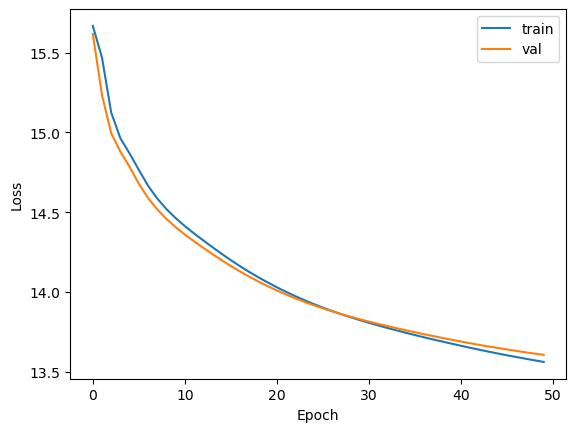

In [76]:
# Train the model
num_epochs = 50
learn_rate = 1e-3
batch_size = 16
criterion = LeastSquareCriterion(num_classes)
train_model(num_epochs, learn_rate, batch_size, model, criterion, X_train, y_train, X_val, y_val)


In [77]:
def evaluate_model(model, X_val, y_val, batch_size):

    num_samples = len(X_val)
    y_pred = []

    for i in range(0, num_samples, batch_size):
        x = X_val[i:i + batch_size]
        outputs = model.forward(x)
        predicted = np.argmax(outputs, axis=1)
        y_pred.extend(predicted)

    y_pred = np.array(y_pred)
    model_accuracy = np.mean(y_pred == y_val)

    return model_accuracy

In [78]:
model_accuracy = evaluate_model(model, X_val, y_val, batch_size)
print('Model accuracy:', model_accuracy)

Model accuracy: 0.27383300460223536


9) In recommender systems, the popularity based model is an important baseline. We have a two part question in this regard: a) Is there a relationship between popularity and average star rating for the 5k songs we have explicit feedback for? b) Which 10 songs are in the “greatest hits” (out of the 5k songs), on the basis of the popularity based model?

In [79]:
# Check if the first 5000 songs in original spotify_data contain songs with 0 popularity
old_spotify_data = pd.read_csv('spotify52kData.csv')
first_5000_songs = old_spotify_data.head(5000)
zero_popularity = first_5000_songs[first_5000_songs['popularity'] == 0]

if not zero_popularity.empty:
    zero_popularity_indices = zero_popularity.index.tolist()
    print(f"Total number of songs with popularity 0 in the first 5000 rows: {len(zero_popularity_indices)}")
else:
    print("There are no songs with popularity 0 in the first 5000 rows.")
    zero_popularity_indices = []

Total number of songs with popularity 0 in the first 5000 rows: 973


In [80]:
# Drop the corresponding columns in ratings_data
ratings_data = pd.read_csv('starRatings.csv', header = None)
ratings_data.drop(zero_popularity_indices, axis=1, inplace=True)
print(ratings_data)


      0     1     2     3     4     5     6     7     8     9     ...  4990  \
0      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
1      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
2      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
3      NaN   3.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
4      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   4.0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
9995   NaN   0.0   0.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
9996   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
9997   3.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
9998   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   0.0   
9999   NaN   1.0   NaN   NaN   NaN   NaN   NaN   4.0   NaN   NaN  ...   NaN   

      4991  4992  4993  4994  4995  4996  4997  499

In [81]:
# a)
# Calculate average rating for each song in ratings_data
average_ratings = ratings_data.mean(axis=0)

# Extract the popularity scores from spotify_data
popularity_scores = spotify_data['popularity'].head(len(average_ratings))

# Calculate the correlation
correlation = average_ratings.corr(popularity_scores)

# Print the correlation
print("Correlation between average star ratings and popularity:", correlation)

Correlation between average star ratings and popularity: 0.5431016902691187


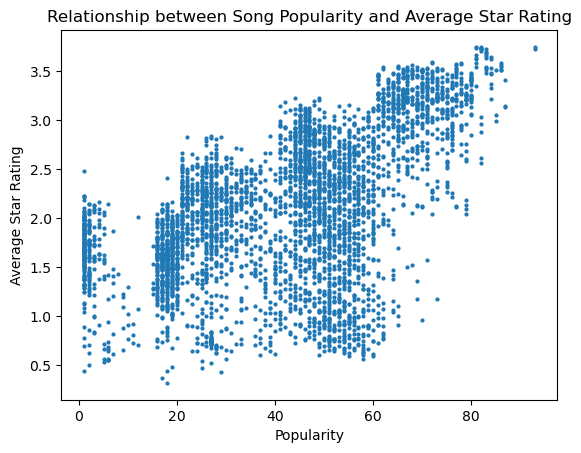

In [82]:
# Visualization
plt.scatter(popularity_scores, average_ratings, s = 4)
plt.xlabel('Popularity')
plt.ylabel('Average Star Rating')
plt.title('Relationship between Song Popularity and Average Star Rating')
plt.show()

In [83]:
# b)
# Only keep songs with at least 100 ratings from ratings_data
counts = ratings_data.count()
songs_with_5_or_more_ratings = counts[counts >= 100].index
ratings_data = ratings_data[songs_with_5_or_more_ratings]
print(ratings_data)

      0     1     2     3     4     5     6     7     8     9     ...  4990  \
0      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
1      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
2      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
3      NaN   3.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
4      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   4.0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
9995   NaN   0.0   0.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
9996   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
9997   3.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
9998   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   0.0   
9999   NaN   1.0   NaN   NaN   NaN   NaN   NaN   4.0   NaN   NaN  ...   NaN   

      4991  4992  4993  4994  4995  4996  4997  499

In [84]:
# Select the top 10 songs with highest average rating (popularity based model)
top_10 = average_ratings.sort_values(ascending=False).head(10)
top_10_songs_artists = old_spotify_data.iloc[top_10.index][['songNumber','track_name','artists']]
top_10_songs_artists['averageRating'] = top_10.values
top_10_songs_artists.reset_index(drop=True, inplace=True)

# Print the results
print("Top 10 Greatest Hits:")
print(top_10_songs_artists)

Top 10 Greatest Hits:
   songNumber                                     track_name  \
0        3877                       You're Gonna Go Far, Kid   
1        3003                                Sweater Weather   
2        2260                                     Can't Stop   
3        2562                       You're Gonna Go Far, Kid   
4        3216                                Californication   
5        2105                                Californication   
6        2003                                Sweater Weather   
7        2011                              Shut Up and Dance   
8        3464                                     Can't Stop   
9        3253  New Gold (feat. Tame Impala and Bootie Brown)   

                             artists  averageRating  
0                      The Offspring       3.750000  
1                  The Neighbourhood       3.748950  
2              Red Hot Chili Peppers       3.744554  
3                      The Offspring       3.743202  
4  

10) You want to create a “personal mixtape” for all 10k users we have explicit feedback for. This mixtape contains individualized recommendations as to which 10 songs (out of the 5k) a given user will enjoy most. How do these recommendations compare to the “greatest hits” from the previous question and how good is your recommender system in making recommendations?

In [91]:
# Load song details (assuming 'songNumber' is the unique identifier for songs)
song_details = pd.read_csv('spotify52kData.csv')
song_details.set_index('songNumber', inplace=True)

# Load ratings data
ratings_data = pd.read_csv('starRatings.csv', header=None)
ratings_data = ratings_data.stack().reset_index()
ratings_data.columns = ['userID', 'songNumber', 'rating']

# Create a Surprise dataset from the ratings dataframe
reader = Reader(rating_scale=(0, 4))
df = Dataset.load_from_df(ratings_data[['userID', 'songNumber', 'rating']], reader)

# Split the dataset into training and test set
trainset, testset = sp_train_test_split(df, test_size=0.2)

# Use the SVD algorithm for recommendations
algo = SVD()

# Train the algorithm on the trainset and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Compute RMSE
accuracy_rmse = rmse(predictions)

RMSE: 1.1051


In [92]:
# Function to get top N predictions for each user
def get_top_n(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(predictions, n=10)

# Print the recommended songs for each user
for uid, user_ratings in top_n.items():
    print(uid, [song_details.loc[iid, 'track_name'] for (iid, _) in user_ratings])

8332 ['White Flag', 'Lips Of An Angel', 'All Star', 'Arriving Somewhere But Not Here', 'Detergente', 'Afraid', 'Boston', 'Melancolía', 'Moments Like This', 'Nangangamba']
7460 ['Rockstar', 'Everybody Talks', 'In Bloom', 'Gladiator', 'Behind Blue Eyes', 'How You Remind Me', 'Lobo', "Don't Let Me Go", 'Bubblegum Bitch', "It's Not Living (If It's Not With You)"]
8172 ['シンデレラ', 'Californication', 'Living Hell', 'Hero', 'Kaleidoscope', 'Black Hole Sun', 'A Cada Vento - Live', 'The Fear', 'Aquí Nadie Esta Sano (feat. Los Auténticos Decadentes)', 'abcdefu (angrier)']
1530 ['You Get Me So High', 'Duality', "The Kids Aren't Alright", 'All Star', 'The Fear', 'Carmela - Remasterizado 2008', 'Comedy', 'Chica Suburbana', 'Mind Over Matter (Reprise)', 'Move on Up']
5583 ['Compass', 'Not Gonna Die', 'Kids', 'Otherside', 'Bella', 'Take A Look Around', 'Keep on Loving You', 'Born For This', 'Laugh While You Can', 'Tearz']
4293 ['Metalingus', 'Metalingus', 'Mr. Brightside', 'Brujería', 'Miss You', 'Blac

5033 ['Are You Satisfied?', 'Passion', 'Boston', 'Never Stop (Wedding Version)', 'Latinoamérica (feat. Totó la Momposina, Susana Baca & Maria Rita)', 'Always Be My Baby', 'SAD GIRLZ LUV MONEY Remix (feat. Kali Uchis and Moliy) - Slowed + Reverb', 'Living My Best Life', 'Black Horse And The Cherry Tree', 'Hard Sometimes']
6291 ['Out of My League', 'Boku no Sensou - TV Size', 'Mr. Brightside', 'Rockstar', 'Tongue Tied', 'Alps', 'abcdefu', 'Lonely', 'Hikare Inochi', 'Aduna Diaroul Niawo']
2148 ['Final Masquerade', 'Chocolate', 'Lying from You', 'Reach Out', 'Miracle', 'Carry Me Home', 'Symphony Of Destruction', 'Painkiller', 'Bitter Sweet Symphony', 'Somebody Told Me']
6577 ['HandClap', 'Monster', 'Why', '透明だった世界', 'My Type', 'Like a Stone', 'Waver', 'Latinoamérica (feat. Totó la Momposina, Susana Baca & Maria Rita)', 'Tengo Luquita', 'Part Of The Band']
9776 ['Smells Like Teen Spirit', 'Unsainted', 'Shallow', 'Legend', 'You Say', 'Demons', 'Lost In The Wild', 'I Am Defiant', 'Vícios E Vi

5197 ['Love Song', 'Unsainted', 'By the Way', 'Fake as Fu@k', 'CASTLE OF GLASS', 'Bella', 'Marigold', 'Meet Me in the Shade', 'Beyond the Clouds', 'Affection']
2622 ['End of Me', 'Hero', 'Tão Seu', 'Duality', 'Carmela - Remasterizado 2008', 'Last Resort', "Tears Don't Fall", 'Coconut', 'Dolls', 'Part Of The Band']
2317 ['Fake Plastic Trees', 'Tendo A Lua - Ao Vivo', 'How to Disappear Completely', 'Bare Wit Me', 'Creep', 'Breaking the Habit', 'The One That Got Away', 'Lunita de Tucumán', 'Chop Suey!', 'Cry Baby']
4381 ['Joker And The Thief', 'Chop Suey!', 'Time to Pretend', 'Bitter Sweet Symphony', 'Latinoamérica (feat. Totó la Momposina, Susana Baca & Maria Rita)', 'Snow (Hey Oh)', 'Animal I Have Become', 'Añejo W', 'Nueve', '100 Years']
2254 ['Shut Up and Dance', 'When You Were Young', 'Run for Your Life', 'Black Hole Sun', 'Born For This', 'Butterfly', "I'm Dangerous", 'This Is Amazing Grace', 'Tanto (I Want You) - Ao Vivo', 'Behind Blue Eyes']
6597 ['Everlong', 'From the Inside', 'A

In [93]:
# Define a threshold for liking a song
like_threshold = 4

# Create a dictionary where keys are user IDs and values are lists of liked song numbers
actual_liked_songs = defaultdict(list)
for _, row in ratings_data.iterrows():
    if row['rating'] >= like_threshold:
        actual_liked_songs[row['userID']].append(row['songNumber'])

In [94]:
# average_precision_at_k function
def average_precision_at_k(actual, predicted, k = 10):
    if not actual:
        return 0

    actual_set = set(actual)
    predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual_set:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    return score / min(len(actual), k)

# mean_average_precision_at_k
def mean_average_precision_at_k(actual, predicted, k = 10):
    return np.mean([average_precision_at_k(a, p, k) for a, p in zip(actual, predicted)])

In [95]:
# Convert top_n to a list of lists (predicted data)
predicted_data = [[iid for (iid, _) in user_ratings] for user_ratings in top_n.values()]
# Convert actual_liked_songs to a list of lists (actual data)
actual_data = [actual_liked_songs[uid] for uid in top_n.keys()]


In [96]:
# Calculate map_k
map_k = mean_average_precision_at_k(actual_data, predicted_data, k=10)
print(f"Mean Average Precision at 10: {map_k}")

Mean Average Precision at 10: 0.3625819319727891


In [97]:
# Now, compare these recommendations to the "greatest hits"
greatest_hits = top_10_songs_artists[['track_name']]

def overlap(user_recommendations, greatest_hits):
    count = sum(song in greatest_hits for song in user_recommendations)
    return count / len(user_recommendations) * 100

In [98]:
# Calculate the overlap 
predicted_data = [[iid for (iid, _) in user_ratings] for user_ratings in top_n.values()]
overlap_percentages = [overlap(user_recommendations, greatest_hits) for user_recommendations in predicted_data]
average_overlap = sum(overlap_percentages) / len(overlap_percentages)

print(f"Average Overlap with Greatest Hits: {average_overlap}%")

Average Overlap with Greatest Hits: 0.0%


Extra Credit) Hip-hop has become one of the most popular genres of music in the past decades. As a fan of classical music, I want to know if hip-hop songs are more popular than classical songs.

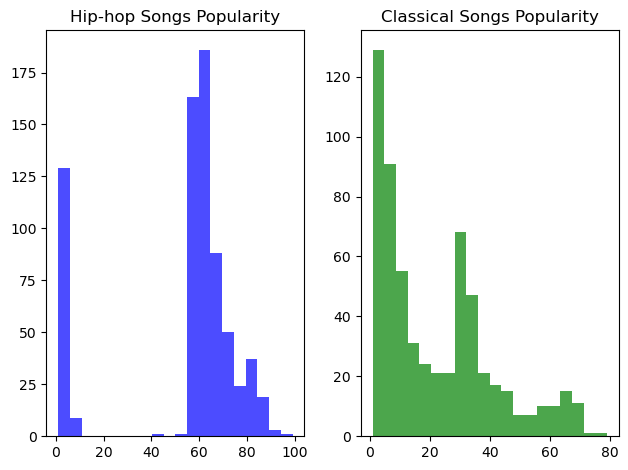

In [99]:
# Extract two groups of data
hippop_songs = spotify_data[spotify_data['track_genre'] == 'hip-hop']['popularity']
classical_songs = spotify_data[spotify_data['track_genre'] == 'classical']['popularity']

# Plot histogram to determine which test to perform
plt.subplot(1, 2, 1)
plt.hist(hippop_songs, bins=20, alpha=0.7, color='blue')
plt.title('Hip-hop Songs Popularity')
plt.subplot(1, 2, 2)
plt.hist(classical_songs, bins=20, alpha=0.7, color='green')
plt.title('Classical Songs Popularity')
plt.tight_layout()
plt.show()

In [100]:
# Perform Mann-Whitney U test
u_stats, p_val = mannwhitneyu(hippop_songs, classical_songs, alternative='greater')
print("U-statistic:", u_stats)
print("P-value:", p_val)

if p_val < 0.05:
    print("We will reject the null.")
else:
    print("We fail to reject the null")



U-statistic: 339971.5
P-value: 5.683108329073504e-76
We will reject the null.
